In [1]:
import os
import json
import torch
from PIL import Image
from tqdm import tqdm
import numpy as np
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor

TEXT_DIR = '/data/guojian.li/Dataset/MSTI/Textual sentences/test'  # 假设文本在此目录
VISUAL_LABEL_DIR = '/data/guojian.li/Dataset/MSTI/Visual target labels/'
IMAGE_DIR = '/data/guojian.li/Dataset/MSTI/img'
MODEL_PATH = '/data/guojian.li/Weight/Qwen2.5-VL-7B-Instruct'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2", device_map=DEVICE)
processor = AutoProcessor.from_pretrained(MODEL_PATH)


/opt/conda/envs/video-r1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-06-30 15:00:32,841] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
import xml.etree.ElementTree as ET

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def decode_xml_points(text):
    try:
        root = ET.fromstring(text)
        num_points = (len(root.attrib) - 1) // 2
        points = []
        for i in range(num_points):
            x = root.attrib.get(f'x{i+1}')
            y = root.attrib.get(f'y{i+1}')
            points.append([x, y])
        alt = root.attrib.get('alt')
        phrase = root.text.strip() if root.text else None
        return {
            "points": points,
            "alt": alt,
            "phrase": phrase
        }
    except Exception as e:
        print(e)
        return None

def plot_bounding_boxes(im, bounding_boxes, input_width, input_height):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    # print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    try:
      json_output = ast.literal_eval(bounding_boxes)
    except Exception as e:
      end_idx = bounding_boxes.rfind('"}') + len('"}')
      truncated_text = bounding_boxes[:end_idx] + "]"
      json_output = ast.literal_eval(truncated_text)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json_output):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      print(f"修改后的坐标 {i}: ({abs_x1}, {abs_y1}), ({abs_x2}, {abs_y2})")

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    img.show()


def plot_points(im, text, input_width, input_height):
  img = im
  width, height = img.size
  draw = ImageDraw.Draw(img)
  colors = [
    'red', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple', 'brown', 'gray',
    'beige', 'turquoise', 'cyan', 'magenta', 'lime', 'navy', 'maroon', 'teal',
    'olive', 'coral', 'lavender', 'violet', 'gold', 'silver',
  ] + additional_colors
  xml_text = text.replace('```xml', '')
  xml_text = xml_text.replace('```', '')
  data = decode_xml_points(xml_text)
  if data is None:
    img.show()
    return
  points = data['points']
  description = data['phrase']

  font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

  for i, point in enumerate(points):
    color = colors[i % len(colors)]
    abs_x1 = int(point[0])/input_width * width
    abs_y1 = int(point[1])/input_height * height
    radius = 2
    draw.ellipse([(abs_x1 - radius, abs_y1 - radius), (abs_x1 + radius, abs_y1 + radius)], fill=color)
    draw.text((abs_x1 + 8, abs_y1 + 6), description, fill=color, font=font)
  
  img.show()
  

# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

In [4]:
def qwen_infer(image_path, text, prompt, model, processor):
    image = Image.open(image_path).convert('RGB')
    messages = [
        {"role": "system", "content": """
            You are a multimodal satire analysis assistant.\n
            Please output strictly in accordance with the following XML-like structure:\n
            '<think> Natural Language Interpretation </think><bbox_2d> coordinates or none</bbox_2d><answer> sarcasm/non-sarcasm </answer>'\n\n
            Explanation:\n
            1. In <think> Explain 'Why judge (not) sarcasm'.\n
            2. <bbox> section:\n
                If answer= sarcasm, give the coordinates of satirical target:'[x1,y1,x2,y2],[x1,y1,x2,y2]'. 
                    The target of satire may be more than one, or there may be none. If not, write single token 'none'.\n
                If answer= non-sarcasm, write single token 'none'.\n
            3. Only output the above three tags. The order of the tags cannot be changed. The tag name, Angle brackets, and slashes must be complete.
    """},
        {"role": "user", "content": [
            {"type": "text", "text": "Text:"+ text +"\n" +  prompt},
            {"image": image_path}
        ]}
    ]
    text_input = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text_input], images=[image], padding=True, return_tensors="pt").to(DEVICE)
    output_ids = model.generate(**inputs, max_new_tokens=512)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

      # 在源码处理中，除以了patch大小，这里需要乘回来
    input_height = inputs['image_grid_thw'][0][1]*14
    input_width = inputs['image_grid_thw'][0][2]*14

    return output_text[0], input_height, input_width

def load_text(text_file):
    with open(text_file, 'r', encoding='utf-8') as f:
        return f.read().strip()
    
def load_gt_boxes(label_file):
    gt_boxes = []
    with open(label_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            # 全为0，直接跳过（class为0的样本）
            if all(p == '0' for p in parts):
                return []  # 直接返回空，主循环会跳过
            i = 0
            while i + 4 < len(parts):
                x1, y1, x2, y2 = map(float, parts[i:i+4])
                # 目标全为0也跳过
                if x1 == 0 and y1 == 0 and x2 == 0 and y2 == 0:
                    i += 5
                    continue
                gt_boxes.append([x1, y1, x2, y2])
                i += 5  # 跳过class字段
    return gt_boxes

[[327.0, 253.0, 419.0, 296.0], [100.0, 315.0, 183.0, 354.0], [85.0, 375.0, 177.0, 417.0], [128.0, 437.0, 219.0, 479.0], [81.0, 550.0, 171.0, 595.0], [69.0, 498.0, 163.0, 539.0], [232.0, 495.0, 337.0, 544.0], [244.0, 553.0, 330.0, 601.0], [286.0, 434.0, 382.0, 472.0]]
修改后的坐标 0: (327, 253), (419, 296)
修改后的坐标 1: (100, 315), (183, 354)
修改后的坐标 2: (85, 375), (177, 417)
修改后的坐标 3: (128, 437), (218, 479)
修改后的坐标 4: (81, 550), (171, 595)
修改后的坐标 5: (69, 498), (163, 539)
修改后的坐标 6: (232, 495), (337, 544)
修改后的坐标 7: (244, 553), (330, 601)
修改后的坐标 8: (286, 434), (382, 472)


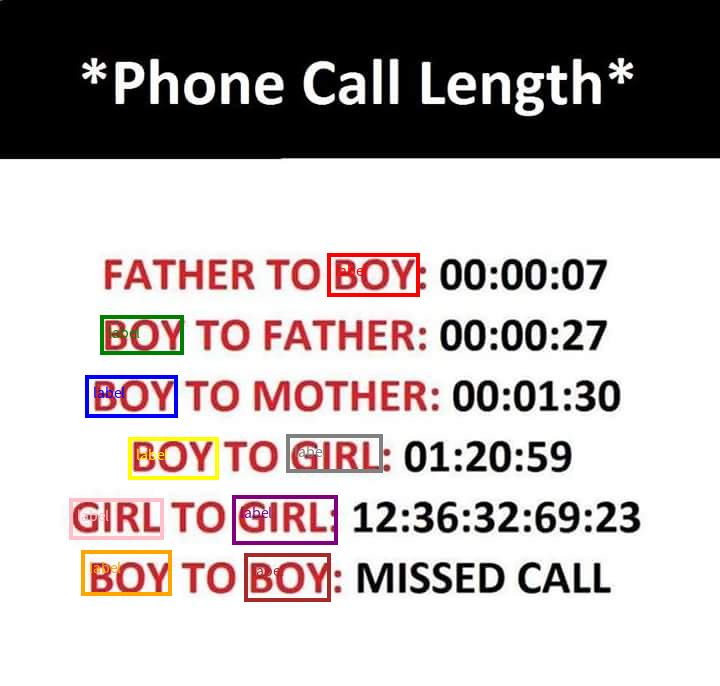

In [23]:
img_path = "/data/guojian.li/Dataset/MSTI/img/7088.jpg"
image = Image.open(img_path)
label_path = os.path.join(VISUAL_LABEL_DIR, '7088.txt')
label = load_gt_boxes(label_path)
print(label)
labels = []
for box in label:
    labels.append({
        "bbox_2d": box,
        "label": "label"
    })
plot_bounding_boxes(image,str(labels),image.size[0],image.size[1])

推文： just found this pic # picoftheday # justsaying emoji_15 emoji_15 emoji_15
真实尺寸： (720, 686)
变换后尺寸： tensor(728, device='cuda:1') tensor(672, device='cuda:1')
真实坐标 [[327.0, 253.0, 419.0, 296.0], [100.0, 315.0, 183.0, 354.0], [85.0, 375.0, 177.0, 417.0], [128.0, 437.0, 219.0, 479.0], [81.0, 550.0, 171.0, 595.0], [69.0, 498.0, 163.0, 539.0], [232.0, 495.0, 337.0, 544.0], [244.0, 553.0, 330.0, 601.0], [286.0, 434.0, 382.0, 472.0]]
模型回答 <think> The text and image together suggest a humorous observation about phone call lengths between different individuals, implying that the boy to girl call is unusually long compared to others. This could be interpreted as a form of satire on the nature of communication between genders.</think>
<bbox_2d> [98,247,628,590]</bbox_2d>
<answer>sarcasm</answer>
模型坐标 [{'bbox_2d': [98, 247, 628, 590], 'label': 'label'}]
修改后的坐标 0: (96, 252), (621, 602)


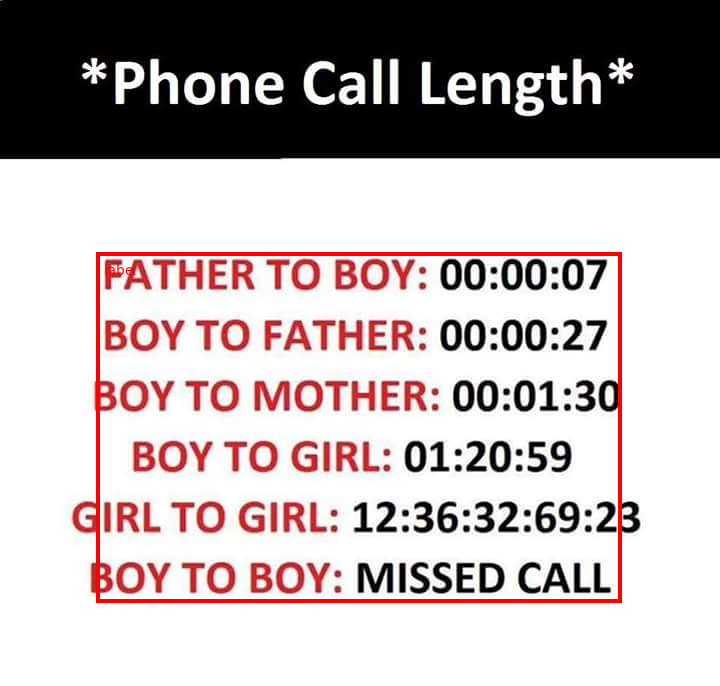

In [36]:
text_path = "/data/guojian.li/Dataset/MSTI/Textual sentences/train/7088.txt"
img_path = "/data/guojian.li/Dataset/MSTI/img/7088.jpg"
image1 = Image.open(img_path)
text = load_text(text_path)
print("推文：",text)
prompt = ("Please judge whether this picture and text are satirical. If so, point out the location of the satirical target and give the reason.\n"
            "There are only two categories: sarcasm and non-sarcasm. Just output it in the prescribed format. No extra text is needed.")
response, input_height, input_width = qwen_infer(img_path, text, prompt, model, processor)
print("真实尺寸：",image.size)
print("变换后尺寸：",input_width,input_height)
print("真实坐标",label)
print("模型回答",response)

import re
answewr = ""
match = re.search(r'<bbox_2d>(.*?)</bbox_2d>', string=response)
if match:
    answer = match.group(1)

matches = re.findall(r'\[([^\]]+)\]', answer)
result = [list(map(int, item.split(','))) for item in matches]

labels = []
for box in result:
    labels.append({
        "bbox_2d": box,
        "label": "label"
    })
print("模型坐标",labels)
plot_bounding_boxes(image1,str(labels),input_width,input_height)

In [34]:
import re

s = "[5456,y1,x2,y2],[x3,y3,x4,y4]"
matches = re.findall(r'\[([^\]]+)\]', s)
result = [item.split(',') for item in matches]

print(result)


[['5456', 'y1', 'x2', 'y2'], ['x3', 'y3', 'x4', 'y4']]


In [10]:
if len([[]]) == 0:
    print("列表为空")
else:
    print("列表不为空")

列表不为空
